In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import cv2

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

In [3]:
import torch.multiprocessing as multiprocessing
# import multiprocessing as multiprocessing

multiprocessing.set_start_method('forkserver')

In [4]:
import resource

rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (2048 * 4, rlimit[1]))

In [5]:
import torch
import torch.nn.functional as F

from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [6]:
import os, random, collections
import pandas as pd
# import cv2
import numpy as np
import pandas as pd
import pickle

from glob import glob

from tqdm import tqdm as tqdm
from IPython.display import clear_output

from torchvision import transforms

In [7]:
from collections import defaultdict

In [8]:
import sys
sys.path.append('/root/inplace_abn/')
sys.path.append('..')


from zoo.unet import DPNUnet
from zoo.dpn import dpn92
from zoo.resnext import ResNeXt101_64x4d, resnext101_64x4d
from utils.classification_dataset import ISIC_Dataset, EqualizedSampler, ValSampler, MEAN, STD, ATTRIBUTES
%load_ext autoreload
%autoreload 2


from utils.attributes_augmentations import Augmentation

from utils.losses import BCEDiceJaccardLoss
from utils.metrics import calc_iou
from utils.hard_negative import HardNegativeMiner
from utils.cyclic_lr import CyclicLR, ExpLR


In [9]:
import os

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]=["0", "1"]
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [10]:
# GPU_IDX = 1
EPS = 1e-5
LR_GAMMA = .95
SEED = 42
VRS_NB = 3

CLASS_NB = 7
DECAY_EPOCHS = 13
EPOCHS_NB = DECAY_EPOCHS + 0

model_pth = 'attributes_checkpoints/fpn_dpn92/fold_{}_checkpoint.epoch_39'

PATHS = {
    'DATA': '../data/ISIC2018_Task3_Training_Input/',
    'CSV': '../data/ISIC2018_Task3_Training_GroundTruth/\
ISIC2018_Task3_Training_GroundTruth.csv'

}

In [11]:
import itertools
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          axes=None, fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if axes is None:
        axes = plt
        fig = plt
    cax = axes.imshow(cm_norm, interpolation='nearest', cmap=cmap)
    axes.set_title(title)
    fig.colorbar(cax)
    tick_marks = np.arange(len(classes))
    axes.set_xticks(tick_marks)
    axes.set_xticklabels(classes)
    axes.set_yticks(tick_marks)
    axes.set_yticklabels(classes)
    axes.tick_params(axis='x', rotation=30)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')


In [12]:
def infer_on_dataset(model, dataset, idx, verbose=False, suffix=''):
    data = dataset[(dataset.keys[idx], 0)]
    pred_mask = F.sigmoid(
        model.forward(Variable(data['images'].unsqueeze(0)).cuda())[0]
    ).data.cpu().numpy()
    
    image = (data['images'].numpy().T * STD + MEAN)[..., ::-1]
    true_mask = data['masks'].numpy().T
    channel = np.unique(np.where(true_mask)[-1]).min()
    pred_mask = pred_mask.T[..., channel]
    true_mask = true_mask[..., channel]
    
    if verbose:
        _, ax = plt.subplots(ncols=3, figsize=(15, 5))
        ax[0].imshow(image)
        ax[1].imshow(true_mask)
        ax[2].imshow(pred_mask)
    np.save('pics/image_{}'.format(suffix), image)
    np.save('pics/pred_mask_{}'.format(suffix), pred_mask)
    np.save('pics/true_mask_{}'.format(suffix), true_mask)

In [13]:
CUDA_IDX = 0
torch.cuda.set_device(CUDA_IDX)

In [14]:
# def freeze(model, freeze=True):
#     for child in model.children():
#         for param in child.parameters():
#             param.requires_grad != freeze
#     return model

# def unfreeze_bn(model):
#     if isinstance(model, nn.BatchNorm2d):
#         for param in model.parameters():
#             param.requires_grad = True

#     model = list(model.children())
#     if len(model):
#         for child in model:
#             unfreeze_bn(child)
#     return None

# def unfreeze_clf(model):
#     for child in model.children():
#         if isinstance(child, nn.Conv2d):
#             clf = child
#     for param in clf.parameters():
#         param.requires_grad = True

#     return model


In [15]:
def freeze(model, freeze_=True):
    if hasattr(model, 'children') and len(list(model.children())):
        model = list(model.children())
        for child in model:
            freeze(child, freeze_)
    elif hasattr(model, 'parameters'):
        for param in model.parameters():
            param.requires_grad = not freeze_

def unfreeze_bn(model):
    if isinstance(model, nn.BatchNorm2d):
        for param in model.parameters():
            param.requires_grad = True

    model = list(model.children())
    if len(model):
        for child in model:
            unfreeze_bn(child)
    return None

def unfreeze_clf(model):
    if hasattr(model, 'classifier'):
        for param in model.classifier.parameters():
            param.requires_grad = True
    if hasattr(model, 'last_linear'):
        for param in model.last_linear.parameters():
            param.requires_grad = True
    elif len(list(model.children())):
        for child in model.children():
            unfreeze_clf(child)

In [16]:
def get_datasets(data_dir, fold, df, aug_strength=1.):
    train_dataset = ISIC_Dataset(data_dir, df, seed=SEED,
                                 augmentator=Augmentation, aug_params={
                                     'side': 448, 
                                     'strength': aug_strength
                                 }, is_test=True, part=fold, partsamount=4, exclude=True)
    val_dataset = ISIC_Dataset(data_dir, df, seed=SEED,
                               augmentator=Augmentation, aug_params={
                                   'side': 448
                               }, 
                               is_test=True, part=fold, partsamount=4, exclude=False)
    return train_dataset, val_dataset


def get_datagens(train_dataset, val_dataset, df, train_batch_size=28):
    train_datagen = torch.utils.data.DataLoader(train_dataset, pin_memory=False,
                                                sampler=EqualizedSampler(train_dataset, df), 
                                                batch_size=train_batch_size, 
                                                num_workers=0)
    val_datagen = torch.utils.data.DataLoader(val_dataset,
                                              sampler=ValSampler(val_dataset, df), 
                                              batch_size=16,
                                              num_workers=0)
    return train_datagen, val_datagen


def get_model(checkpoint=None, map_location=None, devices=None):
#     model = dpn92(3, 7, pretrained='imagenet+5k')
    model = resnext101_64x4d(num_classes=7, pretrained='imagenet')
    model.cuda();

    if checkpoint is not None:
        sd = torch.load(checkpoint, map_location)#.module.state_dict()
        msd = model.state_dict()
        sd = {k: v for k, v in sd.items() if k in msd}
        print('Overlapped keys: {}'.format(len(sd.keys())))
        msd.update(sd)
        model.load_state_dict(msd)

    if devices is not None:
        model = torch.nn.DataParallel(model, device_ids=devices)

    return model

In [17]:
def make_step(model, data, loss, opt=None, training=True):
    images = Variable(data['images']).cuda()
    masks = Variable(data['class']).cuda()

    predictions = model(images)
    l = loss(predictions, masks)
    pred = F.softmax(
        predictions,
        dim=1
    ).data.cpu().numpy()

    if training:
        l.backward()
        opt.step()

    return {
        'loss': l, 
        'preds': pred,
        'trues': data['class'].data.cpu().numpy()
    }

In [18]:
def train_on_epoch(model, loss, opt, datagen, epsilon=1e-5, hard_negative_miner=None, lr_scheduler=None):
    model.train()
    meters = list()
    preds = list()

    for images_, class_ in tqdm(datagen):
        opt.zero_grad()
        data = {
            'images': images_, 
            'class': class_[:, 0]
        }
        meters.append(make_step(model, data, loss, opt, training=True))
        preds.append({key: meters[-1][key] for key in ['preds', 'trues']})
        if lr_scheduler is not None:
            if hasattr(lr_scheduler, 'batch_step'):
                lr_scheduler.batch_step()

        if hard_negative_miner is not None:
            hard_negative_miner.update_cache(meters[-1], data)
            if hard_negative_miner.need_iter():
                make_step(model, hard_negative_miner.get_cache(), loss, opt, training=True)
                hard_negative_miner.invalidate_cache()

    losses = sum([meter['loss'] for meter in meters])
    losses = losses.data.cpu().numpy() / len(meters)
    pred = np.concatenate([
        meter['preds'] for meter in meters
    ], axis=0)
    trues = np.concatenate([
        meter['trues'] for meter in meters
    ], axis=0)
    pred = np.argmax(pred, axis=1)
    opt.zero_grad()

    return losses, pred, trues

In [19]:
def validate(model, loss, datagen):
    model.eval()
    trues, preds, losses = list(), list(), list()

    with torch.no_grad():
        for images_, class_ in tqdm(datagen):
            meter = make_step(model, {
                'images': images_, 
                'class': class_[:, 0]
            }, loss, training=False)
            preds.append(meter['preds'])
            trues.append(meter['trues'])
            losses.append(meter['loss'].data.cpu().numpy())
    
    pred = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    pred = np.argmax(pred, axis=1)

    return losses, pred, trues

In [20]:
def visualize(train_losses, val_losses, train_preds, val_preds, train_trues, val_trues):
    clear_output(wait=True)
    #np.set_printoptions(precision=2)
    
    train_cnf_matrix = [confusion_matrix(t, p) for t, p in zip(train_trues, train_preds)]
    train_accs = np.array([cnf.diagonal() / cnf.sum(1) for cnf in train_cnf_matrix])
    train_accuraacy = np.mean(train_accs, axis=1)

    val_cnf_matrix = [confusion_matrix(t, p) for t, p in zip(val_trues, val_preds)]
    val_accs = np.array([cnf.diagonal() / cnf.sum(1) for cnf in val_cnf_matrix])
    val_accuraacy = np.mean(val_accs, axis=1)

    plt.figure()
    _, axes = plt.subplots(ncols=2, figsize=(15, 6))

    axes[0].plot(train_losses, label='Train loss')
    axes[0].plot(val_losses, label='Val loss')
    axes[0].plot(train_accuraacy, label='Train acc')
    axes[0].plot(val_accuraacy, label='Val acc')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid()

    for i in range(CLASS_NB):
        axes[1].plot([v[i] for v in train_accs], label='Train {}'.format(ATTRIBUTES[i]), alpha=0.7)
    
    for i in range(CLASS_NB):
        axes[1].plot([v[i] for v in val_accs], label='Val {}'.format(ATTRIBUTES[i]), alpha=0.7)

    axes[1].set_title('Accs')
    axes[1].legend()
    axes[1].grid()

    plt.show()

    # Plot non-normalized confusion matrix
    fig = plt.figure(figsize=(15, 6))
    axes = fig.add_subplot(121)
    plot_confusion_matrix(train_cnf_matrix[-1], classes=ATTRIBUTES,
                          title='Train confusion matrix',
                          axes=axes, fig=fig);
    axes = fig.add_subplot(122)
    plot_confusion_matrix(val_cnf_matrix[-1], classes=ATTRIBUTES,
                          title='Val confusion matrix',
                          axes=axes, fig=fig);
    plt.show()

In [21]:
def dump_intermediates(model, val_dataset, fold, epoch_i):
    model.eval()
    infer_on_dataset(
        model, val_dataset, idx=0, verbose=False, suffix='fold_{}_val_idx_{}_epoch_{}'.format(fold, 0, epoch_i)
    )
    infer_on_dataset(
        model, val_dataset, idx=32, verbose=False, suffix='fold_{}_val_idx_{}_epoch_{}'.format(fold, 32, epoch_i)
    )
    infer_on_dataset(
        model, val_dataset, idx=0, verbose=True, suffix='fold_{}_val_idx_{}_epoch_{}'.format(fold, 17, epoch_i)
    )

In [22]:
def prepare_hyps(model, epoch_i, 
                 clf_freeze_iter=1, sgd_iter=4, verbose=True, iters_in_epoch=800):
    freeze(model, freeze_=(epoch_i <= clf_freeze_iter))
    unfreeze_bn(model)
    unfreeze_clf(model)
    params = filter(lambda p: p.requires_grad, model.parameters())

    if epoch_i <= clf_freeze_iter:
#         opt = optim.Adam(params, lr=5e-4)
        opt = optim.SGD(params, momentum=.9, lr=5e-4, nesterov=True)
    elif epoch_i <= sgd_iter:
        opt = optim.SGD(params, momentum=.9, lr=4e-4, nesterov=True)
        epoch_i -= max(0, clf_freeze_iter)
    else:
        opt = optim.Adam(params, lr=5e-5)
        epoch_i -= max(0, sgd_iter)

    for group in opt.param_groups:
        group.setdefault('initial_lr', group['lr'])

    #todo: #### KOSTIL ####
    if epoch_i <= DECAY_EPOCHS:
        lr_scheduler = optim.lr_scheduler.ExponentialLR(opt, LR_GAMMA, epoch_i - 1)
    else:
        print('Epoch #{} \niters in epoch: {}'.format(epoch_i, iters_in_epoch))
        lr_scheduler = ExpLR(
            opt, src_lr=5e-4, dst_lr=1e-5, 
            step_size=iters_in_epoch,
            last_batch_iteration=epoch_i * iters_in_epoch - 1
        )
#         lr_scheduler = CyclicLR(
#             opt, base_lr=5e-5, max_lr=4e-4, step_size=700, 
#             mode='triangular2', last_batch_iteration=epoch_i * iters_in_epoch - 1)

    if verbose:
        print(opt)

    return {
        'lr_scheduler': lr_scheduler,
        'opt': opt,
    }

In [23]:
def orchestrate(data_dir, fold, df, model=None, losses=None, model_pth=None, 
                epoch_nb=1, map_location=None, clf_freeze_iter=1, sgd_iter=4,
                postfix='', aug_strength=1., hard_negative_miner=None,
                checkpoints_pth='checkpoints', verbose=False, devices=None, 
                train_batch_size=8, lr_scheduler=None, strength_decay=1., 
                min_strength=.7, converge_appearence=.1):

    if checkpoints_pth is not None:
        path = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}' + postfix)
    if model is None:
        model = get_model(model_pth, map_location, devices)
    if model_pth is not None:
        pl = path.format(fold, 'loss')
        if os.path.isfile(pl):
            losses = pickle.load(open(pl, 'rb'))
    if losses is None:
        losses = defaultdict(list)
    last_epoch = len(losses['train_pred'])
    print('last_epoch: {}'.format(last_epoch))

    loss = nn.CrossEntropyLoss()

    try:
        for epoch_i in range(last_epoch, epoch_nb):
            train_dataset, val_dataset = get_datasets(
                data_dir, fold, df=df, 
                aug_strength=aug_strength * strength_decay ** epoch_i
            )
            train_datagen, val_datagen = get_datagens(
                train_dataset, val_dataset, df=df, 
                train_batch_size=train_batch_size
            )

            hyps = prepare_hyps(
                model, epoch_i, clf_freeze_iter, sgd_iter, verbose, len(train_datagen))
            if hasattr(hyps['lr_scheduler'], 'step'):
                hyps['lr_scheduler'].step()

            l, pred, trues = train_on_epoch(
                model, loss, hyps['opt'], train_datagen, 
                hard_negative_miner=hard_negative_miner,
                lr_scheduler=None if DECAY_EPOCHS >= epoch_i else hyps['lr_scheduler']
            )
            losses['train_losses'].append(l)
            losses['train_pred'].append(pred)
            losses['train_trues'].append(trues)

            l, pred, trues = validate(model, loss, val_datagen)
            losses['val_losses'].append(np.mean(l))
            losses['val_pred'].append(pred)
            losses['val_trues'].append(trues)

            if verbose:
                visualize(
                    losses['train_losses'], 
                    losses['val_losses'], 
                    losses['train_pred'],
                    losses['val_pred'],
                    losses['train_trues'],
                    losses['val_trues']
                )

            if train_dataset.aug_params['strength'] > min_strength:
                train_dataset.aug_strength_decay(strength_decay)

            if (checkpoints_pth is not None) and ((epoch_i) % 1 == 0):
#                 torch.save(model, path.format(fold, epoch_i))
                torch.save(model.module.state_dict(), 
                           path.format(fold, epoch_i))
                pickle.dump(losses, open(path.format(fold, 'loss'), 'wb'))
                print(path)

            train_dataset.converge_appearence(decay=converge_appearence)

    except KeyboardInterrupt:
        return model, losses

    return model, losses

In [24]:
import pandas as pd

DECAY_EPOCHS = -1
template = 'classification_checkpoints/best_resnext101_64/fold_{}_checkpoint.epoch_{}'
df = pd.read_csv(PATHS['CSV'])

In [25]:
fold = 0
checkpoints_pth = 'snapshot_emb/'
postfix = '_pnt{}_vrs{}'
model_points = glob(template.format(fold, '*'))

for point, model_pth in enumerate(model_points):
    for vrs in range(VRS_NB):

        path = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_1' + postfix)
        if os.path.isfile(path.format(fold, point, vrs)):
            continue

        print('Model path: {}'.format(model_pth))
        print('point: {}, vrs: {}'.format(point, vrs))

        _, losses = orchestrate(
            data_dir=PATHS['DATA'],
            fold=fold,
            df=df,
            postfix=postfix.format(point, vrs),
            epoch_nb=2,
            checkpoints_pth=checkpoints_pth, 
            model_pth=model_pth,
            aug_strength=1.,
            converge_appearence=.0,
            strength_decay=.97,
            min_strength=0.,
            verbose=True,
            train_batch_size=8,
            clf_freeze_iter=-1,
            sgd_iter=EPOCHS_NB,
            hard_negative_miner=HardNegativeMiner(rate=10),
            lr_scheduler=optim.lr_scheduler.ExponentialLR,
            devices=[0, 1]
        )

In [25]:
def devide_sd(sd, coef=1):
    for k, v in sd.items():
        sd[k] = v / coef
    return sd


def combine(model_pth, fold, pnt):
    model1 = get_model(checkpoint=model_pth)
    model2 = [get_model(
        checkpoint='snapshot_emb/fold_{}_checkpoint.epoch_0_pnt{}_vrs{}'.format(fold, pnt, i)) for i in range(3)]
    models = [model1] + model2
    return models


def combine1(model_pth, fold, pnt):
#     model1 = get_model(checkpoint=model_pth)
    model2 = [get_model(
        checkpoint='snapshot_emb/fold_{}_checkpoint.epoch_0_pnt{}_vrs{}'.format(fold, pnt, i)) for i in range(3)]
#     models = [model1] + model2
    return model2


def combine2(model_pths):
    model2 = [get_model(checkpoint=pth) for pth in model_pths]
#     models = [model1] + model2
    return model2


def blender(models):
    sds = [model.state_dict() for model in models]
    sd = devide_sd(sds[0], len(sds))
    for i, sd_ in enumerate(sds[1:]):
        for k, v in devide_sd(sd_, len(sds)).items():
            sd[k] += v

    msd = models[0].state_dict()
    sd = {k: v for k, v in sd.items() if k in msd.keys()}
    print('Overlapped keys: {}'.format(len(sd.keys())))
    msd.update(sd)
    models[0].load_state_dict(msd)
    return models[0]


In [26]:
def compute_acc(model, fold, df):
    t, v = get_datasets(PATHS['DATA'], fold, df, 1)
    _, v = get_datagens(t, v, df, 8)
    l, pred, trues = validate(model, nn.CrossEntropyLoss(), v)

    cnf_matrix = [confusion_matrix(t, p) 
                    for t, p in zip([trues], [pred])]
    accs = np.array([cnf.diagonal() / cnf.sum(1) for cnf in cnf_matrix])
    print(np.mean(accs, axis=1))

    fig = plt.figure()
    axes = fig.add_subplot(111)
    CLASSES = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
    plot_confusion_matrix(cnf_matrix[-1], classes=CLASSES, fig=fig, axes=axes)
    plt.show()
    return accs, cnf_matrix

Model path: classification_checkpoints/best_resnext101_64/fold_0_checkpoint.epoch_3 
fold: 0, point: 0
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520


  0%|          | 0/7512 [00:00<?, ?it/s]

Overlapped keys: 522
Overlapped keys: 522


100%|██████████| 157/157 [01:39<00:00,  1.58it/s]


[0.83966232]


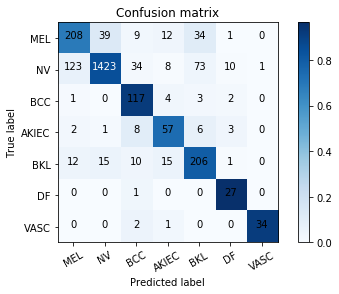

Model path: classification_checkpoints/best_resnext101_64/fold_0_checkpoint.epoch_5 
fold: 0, point: 1
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520


  0%|          | 0/7512 [00:00<?, ?it/s]

Overlapped keys: 522
Overlapped keys: 522


100%|██████████| 157/157 [01:39<00:00,  1.58it/s]


[0.84497141]


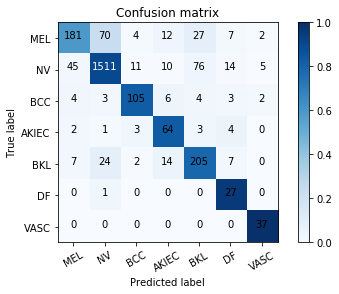

Model path: classification_checkpoints/best_resnext101_64/fold_1_checkpoint.epoch_6 
fold: 1, point: 0
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520


  0%|          | 0/7512 [00:00<?, ?it/s]

Overlapped keys: 522
Overlapped keys: 522


100%|██████████| 157/157 [01:40<00:00,  1.57it/s]


[0.80554394]


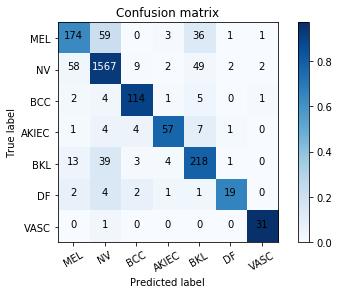

Model path: classification_checkpoints/best_resnext101_64/fold_1_checkpoint.epoch_9 
fold: 1, point: 1
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520


  0%|          | 0/7512 [00:00<?, ?it/s]

Overlapped keys: 522
Overlapped keys: 522


100%|██████████| 157/157 [01:39<00:00,  1.57it/s]

[0.80832272]


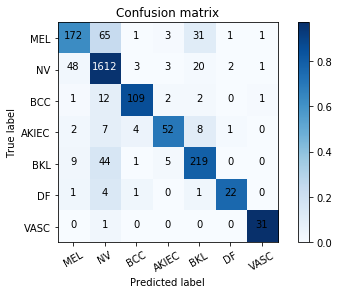

Model path: classification_checkpoints/best_resnext101_64/fold_2_checkpoint.epoch_10 
fold: 2, point: 0
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520


  0%|          | 0/7512 [00:00<?, ?it/s]

Overlapped keys: 522
Overlapped keys: 522


100%|██████████| 157/157 [01:39<00:00,  1.57it/s]


[0.77137613]


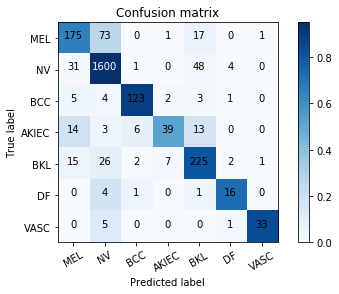

Model path: classification_checkpoints/best_resnext101_64/fold_2_checkpoint.epoch_6 
fold: 2, point: 1
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520


  0%|          | 0/7512 [00:00<?, ?it/s]

Overlapped keys: 522
Overlapped keys: 522


100%|██████████| 157/157 [01:41<00:00,  1.55it/s]


[0.79218774]


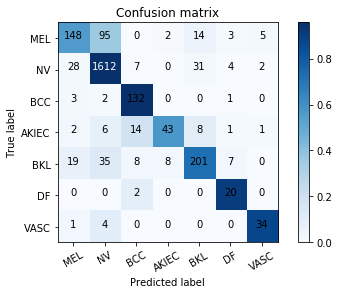

Model path: classification_checkpoints/best_resnext101_64/fold_3_checkpoint.epoch_6 
fold: 3, point: 0
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520


  0%|          | 0/7512 [00:00<?, ?it/s]

Overlapped keys: 522
Overlapped keys: 522


100%|██████████| 157/157 [01:43<00:00,  1.51it/s]


[0.78588167]


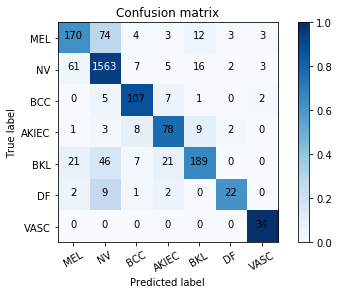

Model path: classification_checkpoints/best_resnext101_64/fold_3_checkpoint.epoch_4 
fold: 3, point: 1
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520


  0%|          | 0/7512 [00:00<?, ?it/s]

Overlapped keys: 522
Overlapped keys: 522


100%|██████████| 157/157 [01:44<00:00,  1.50it/s]


[0.77192509]


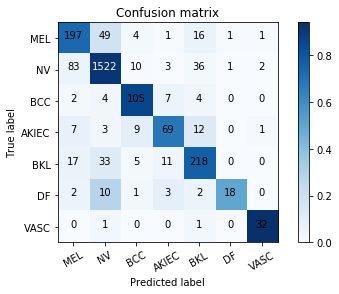

In [30]:
accses, cnfs = list(), list()
for fold in range(4):
    model_points = glob(template.format(fold, '*'))
    for point, model_pth in enumerate(model_points):
        print('Model path: {} \nfold: {}, point: {}'.format(model_pth, fold, point))
        models = combine(model_pth, fold, point)
        model = blender(models)
        accs, cnf = compute_acc(model, fold, df)
        accses.append(accs)
        cnfs.append(cnf)

Model path: c 
fold: 0, point: both
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520


  0%|          | 0/7512 [00:00<?, ?it/s]

Overlapped keys: 522
Overlapped keys: 522


100%|██████████| 157/157 [01:36<00:00,  1.62it/s]

[0.82829435]


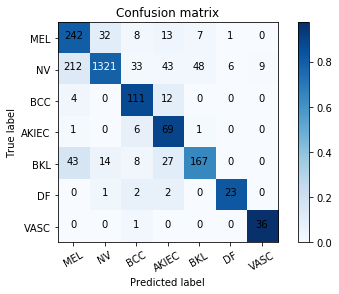

Model path: c 
fold: 1, point: both
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520


  0%|          | 0/7512 [00:00<?, ?it/s]

Overlapped keys: 522
Overlapped keys: 522


100%|██████████| 157/157 [01:37<00:00,  1.61it/s]

[0.79755225]


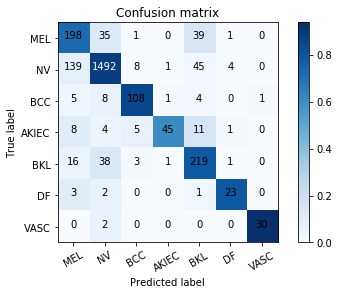

Model path: c 
fold: 2, point: both
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520


  0%|          | 0/7512 [00:00<?, ?it/s]

Overlapped keys: 522
Overlapped keys: 522


100%|██████████| 157/157 [01:37<00:00,  1.61it/s]


[0.79652088]


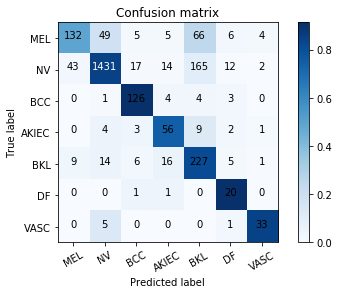

Model path: c 
fold: 3, point: both
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520


  0%|          | 0/7512 [00:00<?, ?it/s]

Overlapped keys: 522
Overlapped keys: 522


100%|██████████| 157/157 [01:37<00:00,  1.61it/s]


[0.77391915]


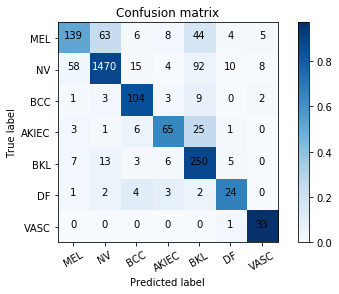

In [35]:
accses, cnfs = list(), list()
for fold in range(4):
    model_points = glob(template.format(fold, '*'))
    print('Model path: {} \nfold: {}, point: {}'.format(model_points[0], fold, 'both'))
    models = combine2(model_points)
    model = blender(models)
    accs, cnf = compute_acc(model, fold, df)
    accses.append(accs)
    cnfs.append(cnf)

# Classification Inferens 

In [25]:
from torchvision.transforms import ToTensor, Normalize, Compose
from utils.smooth_tiled_predictions import predict_img_with_smooth_windowing


img_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.57053024, 0.54612805, 0.76352107], std=[0.09505704, 0.0857232 , 0.09826472])
])

In [26]:
def devide_sd(sd, coef=1):
    for k, v in sd.items():
        sd[k] = v / coef
    return sd


def combine(model_pth, fold, pnt):
    model1 = get_model(checkpoint=model_pth)
    model2 = [get_model(
        checkpoint='snapshot_emb/fold_{}_checkpoint.epoch_0_pnt{}_vrs{}'.format(fold, pnt, i)) for i in range(3)]
    models = [model1] + model2
    return models


def combine1(model_pth, fold, pnt):
#     model1 = get_model(checkpoint=model_pth)
    model2 = [get_model(
        checkpoint='snapshot_emb/fold_{}_checkpoint.epoch_0_pnt{}_vrs{}'.format(fold, pnt, i)) for i in range(3)]
#     models = [model1] + model2
    return model2


def combine2(model_pths):
    model2 = [get_model(checkpoint=pth) for pth in model_pths]
#     models = [model1] + model2
    return model2


def blender(models):
    sds = [model.state_dict() for model in models]
    sd = devide_sd(sds[0], len(sds))
    for i, sd_ in enumerate(sds[1:]):
        for k, v in devide_sd(sd_, len(sds)).items():
            sd[k] += v

    msd = models[0].state_dict()
    sd = {k: v for k, v in sd.items() if k in msd.keys()}
    print('Overlapped keys: {}'.format(len(sd.keys())))
    msd.update(sd)
    models[0].load_state_dict(msd)
    return models[0]


In [27]:
def split_img(im, side=448):
    step = (im.shape[1] - side) // 3
    im = im[1:]
    return np.stack([
        im[:side, i * step: i * step + side]
        for i in range(3)
    ])

In [28]:
def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return np.array(mirrs)


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return np.mean(origs, axis=0)

In [33]:
dataset = ISIC_Dataset(
    '../data/ISIC2018_Task3_Validation_Input/', 
    is_test=True, 
    apply_transform=False
)

100%|██████████| 193/193 [00:00<00:00, 240636.35it/s]


In [34]:
def infer(model, dataset):
    aref_aver = dict()
    geom_aver = dict()
    for i, (k, el) in tqdm(enumerate(dataset.paths.items()), total=len(dataset)):
        img, _ = dataset[k]

        if img.shape != (450, 600, 3):
            print(k, el)

        img = split_img(img)
        img = [_rotate_mirror_do(im) for im in img]
        img = [torch.stack([img_transform(m) for m in im]) for im in img]

        with torch.no_grad():
            predictions = [model(Variable(im).cuda()) for im in img]
            preds = [F.softmax(pred, dim=1).data.cpu().numpy() for pred in predictions]

        preds = np.array(preds).reshape(-1, CLASS_NB)
        aref_aver[k] = preds.mean(0)
        geom_aver[k] = np.product(preds, 0) ** (1 / len(preds))
    return aref_aver, geom_aver

In [36]:
avers = dict()
accses, cnfs = list(), list()

for fold in range(4):
    model_points = glob(template.format(fold, '*'))
    for point, model_pth in enumerate(model_points):
        print('Model path: {} \nfold: {}, point: {}'.format(model_pth, fold, point))
        models = combine(model_pth, fold, point)
        model = blender(models)
        model = torch.nn.DataParallel(model, device_ids=[0, 1])
        model.eval();

        avers[model_pth] = infer(model, dataset)


Model path: classification_checkpoints/best_resnext101_64/fold_0_checkpoint.epoch_3 
fold: 0, point: 0
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520


  0%|          | 0/193 [00:00<?, ?it/s]

Overlapped keys: 522
Overlapped keys: 522


100%|██████████| 193/193 [02:18<00:00,  1.39it/s]


Model path: classification_checkpoints/best_resnext101_64/fold_0_checkpoint.epoch_5 
fold: 0, point: 1
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520


  0%|          | 0/193 [00:00<?, ?it/s]

Overlapped keys: 522
Overlapped keys: 522


100%|██████████| 193/193 [02:16<00:00,  1.41it/s]


Model path: classification_checkpoints/best_resnext101_64/fold_1_checkpoint.epoch_6 
fold: 1, point: 0
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520


  0%|          | 0/193 [00:00<?, ?it/s]

Overlapped keys: 522
Overlapped keys: 522


100%|██████████| 193/193 [02:15<00:00,  1.43it/s]


Model path: classification_checkpoints/best_resnext101_64/fold_1_checkpoint.epoch_9 
fold: 1, point: 1
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520


  0%|          | 0/193 [00:00<?, ?it/s]

Overlapped keys: 522
Overlapped keys: 522


100%|██████████| 193/193 [02:16<00:00,  1.42it/s]


Model path: classification_checkpoints/best_resnext101_64/fold_2_checkpoint.epoch_10 
fold: 2, point: 0
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520


  0%|          | 0/193 [00:00<?, ?it/s]

Overlapped keys: 522
Overlapped keys: 522


100%|██████████| 193/193 [02:16<00:00,  1.42it/s]


Model path: classification_checkpoints/best_resnext101_64/fold_2_checkpoint.epoch_6 
fold: 2, point: 1
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520


  0%|          | 0/193 [00:00<?, ?it/s]

Overlapped keys: 522
Overlapped keys: 522


100%|██████████| 193/193 [02:14<00:00,  1.44it/s]


Model path: classification_checkpoints/best_resnext101_64/fold_3_checkpoint.epoch_6 
fold: 3, point: 0
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520


  0%|          | 0/193 [00:00<?, ?it/s]

Overlapped keys: 522
Overlapped keys: 522


100%|██████████| 193/193 [02:17<00:00,  1.40it/s]


Model path: classification_checkpoints/best_resnext101_64/fold_3_checkpoint.epoch_4 
fold: 3, point: 1
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520
Overlapped keys: 522
Overlapped keys: 520


  0%|          | 0/193 [00:00<?, ?it/s]

Overlapped keys: 522
Overlapped keys: 522


100%|██████████| 193/193 [02:15<00:00,  1.42it/s]


In [37]:
weights = {
    'fold_0_checkpoint.epoch_3': 0.83966232, 
    'fold_0_checkpoint.epoch_5': 0.84497141, 
    'fold_1_checkpoint.epoch_6': 0.80554394, 
    'fold_1_checkpoint.epoch_9': 0.80832272, 
    'fold_2_checkpoint.epoch_10': 0.77137613, 
    'fold_2_checkpoint.epoch_6': 0.79218774, 
    'fold_3_checkpoint.epoch_6': 0.78588167,
    'fold_3_checkpoint.epoch_4': 0.77192509,
}


In [38]:
keys = defaultdict(list)
preds = defaultdict(list)
for model_pth, el in avers.items():
    for k, arr in el[0].items():
        keys[os.path.basename(model_pth)].append(k)
        preds[os.path.basename(model_pth)].append(arr)

# preds = np.array(preds)

In [39]:
for k, el in preds.items():
    preds[k] = np.array(el)

In [40]:
ATTRIBUTES

['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

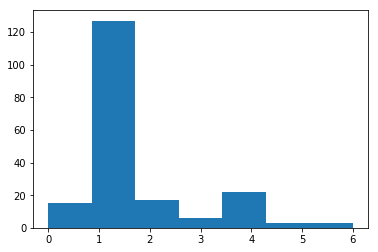

In [41]:
plt.hist(np.argmax(preds[list(preds.keys())[0]], axis=1), 7);

In [42]:
ids_s = dict()
for k, el in preds.items():
    attrs = {
        attr: [pred[i] for pred in preds[k]] 
        for i, attr in enumerate(ATTRIBUTES)
    }
    # attrs.update('image')
    ids = pd.DataFrame({'image': keys[k]})
    for i, attr in enumerate(ATTRIBUTES):
        ids[attr] = [pred[i] for pred in preds[k]]
    ids_s[k] = ids

In [43]:
weights_sum = np.sum(list(weights.values()))
preds = np.sum([
    weights[k] * ids.values[:, 1:] 
    for k, ids in ids_s.items()], axis=0)

In [44]:
# preds = np.mean([ids.values[:, 1:] for ids in ids_s], axis=0)
# preds = np.prod([ids.values[:, 1:] for ids in ids_s], axis=0) ** (1 / CLASS_NB)
args = np.argmax(np.array(preds), axis=1)
for i, arg in enumerate(args):
    preds[i] = 0.
    preds[i, arg] = 1.

In [45]:
attrs = {
    attr: [pred[i] for pred in preds] 
    for i, attr in enumerate(ATTRIBUTES)
}
# attrs.update('image')
ids = pd.DataFrame({'image': ids['image']})
for i, attr in enumerate(ATTRIBUTES):
    ids[attr] = [pred[i] for pred in preds]


In [46]:
ids.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0034368,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,ISIC_0034321,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0034433,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,ISIC_0034338,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,ISIC_0034354,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [47]:
idxs = np.where((ids > .5).sum(1) != 2)[0]
ids.loc[idxs]

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC


In [48]:
ids.to_csv('val_blended_weighted_last.csv', index=False)

In [250]:
# pickle.dump(avers, open('test_dumped', 'wb'))